In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import tqdm
import random
import community as community_louvain

%matplotlib inline

# Core Difference

Weight the connections based on the order of the actor within the movie 

In [6]:
movie_df = pd.read_csv('movie_df.csv', index_col=0)
crew_df = pd.read_csv('crew_df.csv', index_col=0)
cast_df = pd.read_csv('cast_df.csv', index_col=0)

movie_df = movie_df[movie_df.id > 0]
movie_df = movie_df[movie_df.original_title.str.len() > 0]

crew_df = crew_df[crew_df.id > 0]
cast_df = cast_df[cast_df.id > 0]

# Remove movies which we don't have nodes for cause adding edges between nonexisting nodes
# creates new nodes with those new ids, it's annoying
cast_df = cast_df[cast_df.m_id.isin(list(movie_df[movie_df.id >= 0].id.astype(int)))]
crew_df = crew_df[crew_df.m_id.isin(list(movie_df[movie_df.id >= 0].id.astype(int)))]

In [7]:
# So create links of cast and crew linkage, these will need to be labeled in the future, 
# but just start with basic links right now 

# In order to do that we'll have to make length 2 combinations from the different movies each cast member (to start with)
# is in 

from itertools import combinations 

cast_lim = cast_df[cast_df.order <= 20]


# So there's some extra ids in here I want to REMOVE cause they're not in the node_list
# list(combinations(list(cast_lim[cast_lim.id == 2].m_id), 2))
cast_edges = []
cast_property = []

for cast_member in tqdm.tqdm(cast_lim.id.unique()):
    tmp_edg_list = list(combinations(list(cast_lim[cast_lim.id == cast_member].m_id), 2))
    cast_edges.extend(tmp_edg_list)
    cast_property.extend([cast_member] * len(tmp_edg_list))

100%|████████████████████████████████████████████████████████████████████████| 139029/139029 [01:50<00:00, 1256.87it/s]


In [8]:
cast_edges

[(528085, 320288),
 (528085, 399360),
 (528085, 246655),
 (528085, 119450),
 (528085, 77174),
 (528085, 447167),
 (528085, 528888),
 (528085, 41402),
 (528085, 20766),
 (528085, 261103),
 (528085, 91745),
 (528085, 223485),
 (528085, 152795),
 (528085, 215379),
 (320288, 399360),
 (320288, 246655),
 (320288, 119450),
 (320288, 77174),
 (320288, 447167),
 (320288, 528888),
 (320288, 41402),
 (320288, 20766),
 (320288, 261103),
 (320288, 91745),
 (320288, 223485),
 (320288, 152795),
 (320288, 215379),
 (399360, 246655),
 (399360, 119450),
 (399360, 77174),
 (399360, 447167),
 (399360, 528888),
 (399360, 41402),
 (399360, 20766),
 (399360, 261103),
 (399360, 91745),
 (399360, 223485),
 (399360, 152795),
 (399360, 215379),
 (246655, 119450),
 (246655, 77174),
 (246655, 447167),
 (246655, 528888),
 (246655, 41402),
 (246655, 20766),
 (246655, 261103),
 (246655, 91745),
 (246655, 223485),
 (246655, 152795),
 (246655, 215379),
 (119450, 77174),
 (119450, 447167),
 (119450, 528888),
 (119450, 

In [4]:
%%time
G = nx.Graph()

node_list = list(set(movie_df[movie_df.id >= 0].id.astype(int)))
G.add_nodes_from(node_list)
#G.add_edges_from(cast_edges)

# Add property
for x in list(zip(cast_edges, cast_property)):
    G.add_edges_from([x[0]], label=x[1])

Wall time: 23.5 s


In [5]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 23929
Number of edges: 1563103
Average degree: 130.6451


In [6]:
random_nodes = random.sample(list(G.nodes()), 1000)
sub_sample = G.subgraph(random_nodes)

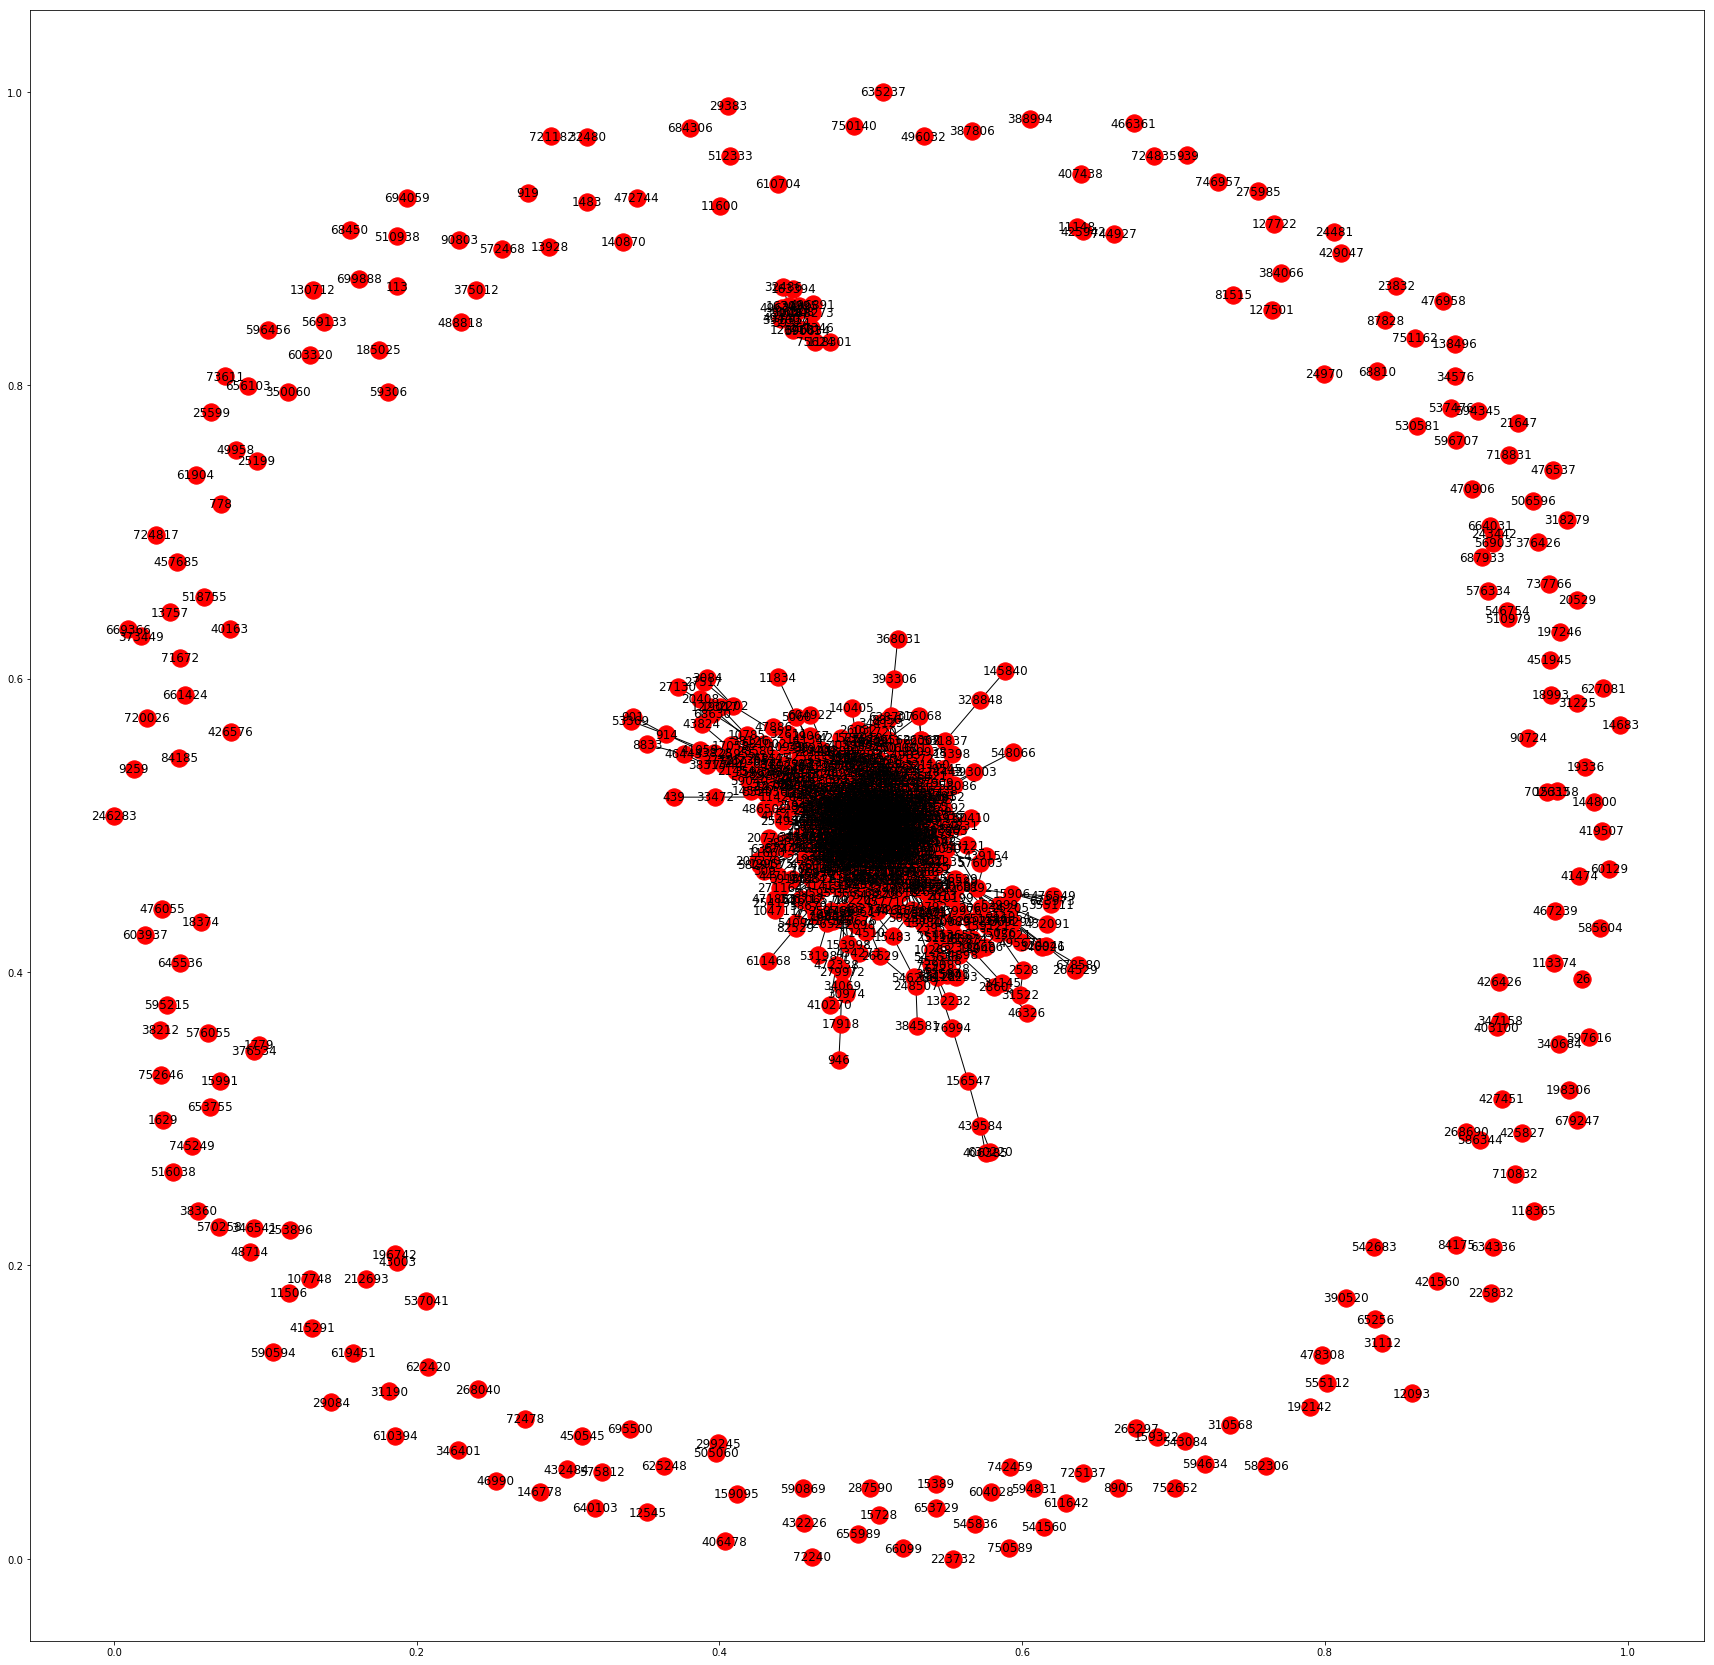

In [7]:
fig, ax = plt.subplots(figsize=(30, 30))

nx.draw_networkx(sub_sample)

In [9]:
%%time
partition = community_louvain.best_partition(G)

Wall time: 8min 29s


In [13]:
movie_df['partition'] = movie_df.id.map(partition)

In [15]:
top_n_rows = movie_df.sort_values('popularity', ascending=False).groupby("partition").head(10)

In [22]:
top_n_rows[top_n_rows.partition == 5]

,adult,id,popularity,original_title,original_langue,release_date,revenue,vote_average,vote_count,budget,partition
7,False,697064.0,626.893,Beckman,NaN,2020-09-10,0.0,4.4,8.0,1200000.0,5
1556,False,740985.0,217.550,Borat Subsequent Moviefilm,NaN,2020-10-23,0.0,6.8,328.0,0.0,5
104,False,290859.0,175.534,Terminator: Dark Fate,NaN,2019-10-23,261119292.0,6.5,2901.0,185000000.0,5
145,False,743227.0,162.054,Wish Upon a Unicorn,NaN,2020-09-15,0.0,7.3,26.0,0.0,5
117,False,594530.0,155.596,Lamp Life,NaN,2020-01-31,0.0,7.3,100.0,0.0,5
357,False,10439.0,129.125,Hocus Pocus,NaN,1993-07-16,39514713.0,7.0,1653.0,28000000.0,5
250,False,309013.0,121.462,Scream at the Devil,NaN,2015-10-30,0.0,5.5,31.0,0.0,5
1168,False,715387.0,111.761,Expulsion,NaN,2020-10-20,0.0,8.0,2.0,0.0,5
228,False,699046.0,109.004,A Perfect Plan,NaN,2020-05-01,0.0,5.2,10.0,0.0,5
207,False,248781.0,104.898,ABCs of Death 2 1/2,NaN,2016-08-02,0.0,4.2,27.0,0.0,5


In [23]:
movie_df.partition.value_counts()

4       5457
5       4157
2       3533
1       2154
6       2132
7       1515
8        901
9        725
10       530
14       406
3        377
15       169
11       169
12       145
16       144
94        10
24         8
484        8
241        8
113        7
370        6
27         6
84         5
288        4
153        4
191        4
547        3
455        3
23         3
149        3
        ... 
986        1
826        1
1002       1
1018       1
1034       1
1050       1
1066       1
1082       1
1098       1
842        1
810        1
522        1
650        1
538        1
554        1
570        1
586        1
602        1
618        1
634        1
666        1
794        1
682        1
698        1
714        1
730        1
746        1
762        1
778        1
0          1
Name: partition, dtype: int64